# Generalized coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

## Definition
For the linear models of the eye and arm, we consider a single-input single-output discrete-time system under control with the following state-update equation:
$$
\tilde{x}_{t+1} = A\tilde{x}_t+B\left (u_t+w_t \right)
$$  
where $\tilde{x}_t$ is the $n$-dimentional state at time $t$, $\tilde{x}_{t+1}$ is the $n$-dimentional state at time $t+dt$, $u_t$ the neural driving signal at time $t$, $w_t$ is a white noise with mean zero and variance $ku_t^2$, $A$ is a fixed $n \times n$ matrix and B is a $n \times 1$ vector both describing the dynamics of the system.

Here, A will be the following matrix:  

$$ A = 
\begin{bmatrix}
1 & dt & \frac{dt^2}{2} & \cdots & \frac{dt^n}{n!}\\
0 & 1 & dt & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots\\
0 & 0 & 0 & 1 & dt \\
0 & \cdots & \cdots & \cdots & 1-\frac{dt\beta}{m}
\end{bmatrix}
\textbf{ }\textbf{ }\textbf{ }\textbf{ }and\textbf{ }\textbf{ }\textbf{ }\textbf{ }
B = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ \frac{dt}{m}\end{bmatrix}
$$  
  
We choose this matrix since, according to the Taylor's formula:  
$ x\left (t+dt \right) = x\left (t \right) + dt\times \dot{x}\left (t \right) + \frac{dt^2}{2}\times \ddot{x}\left (t \right)+ \dots + \frac{dt^n}{n!}\times x^{(n)}\left (t \right) + \mathcal{o}\left(dt^n\right)
$
and  
$x^{(n)}\left (t+dt \right) = \left ( 1 - \frac{dt\beta}{m} \right)x^{(n)}\left (t \right) + \frac{dt}{m}\left (u \left (t\right) + w\left (t\right) \right)
$

In [5]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [257]:
beta = 100 
m = 1
dt = 0.01 # step time
n = 2 # number of coordinates
k = 0.001 # kind of accuracy parameter: the smaller k is, the more accurate is the pointing

In [258]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt*beta/m
B[n-1] = dt/m

In [259]:
t_T = .0 # saccade duration
t_R = 1. # pursuit duration
T = int(t_T/dt)
R = int(t_R/dt)
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.zeros(n) # starting point
xT = np.zeros(n) # ending point
xT[0] = 40
x0[0] = 20
v = 10*np.cos(20*np.pi*time) # velocity of the target (deg/s)

In [263]:
def xT_f(t):
    return np.array([40+5/np.pi*np.sin(4*np.pi*t*dt), 20*np.cos(4*np.pi*t*dt)])

In [264]:
xx = np.zeros(101)
vv = np.zeros(101)
for i in np.arange(101):
    xx[i] = xT_f(i)[0]
    vv[i] = xT_f(i)[1]

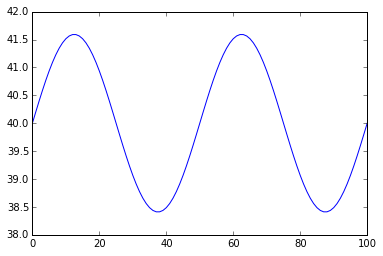

In [265]:
plt.plot(xx)

## Mean and covariance matrix
$\tilde{x}_t = A\tilde{x}_{t-1}+B\left (u_{t-1}+w_{t-1} \right) \\
\tilde{x}_t = A \left (A\tilde{x}_{t-2}+B\left (u_{t-2}+w_{t-2} \right)\right) + B\left (u_{t-1}+w_{t-1} \right) \\
...\\
\tilde{x}_t = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}B \left (u_i+w_i \right)}
$
  
We deduce the mean:
$E\left [\tilde{x}_t \right] = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}Bu_i}$ since $E\left [w_t \right] = 0$.


Then, $cov\left [\tilde{x}_t\right ] = \sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T E\left [w_t^2 \right]} = k\sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T u_t^2}$


  
## Minimum-variance problem
Here, the problem we consider consists in minimizing the sum of the variance of the position after reaching the target. Let $V_t$ be the top-left value in the covariance matrix at time $t$. Then, we want to minimize $\sum \limits_{t=T+1}^{T+R}V_t +bias$. 

In [266]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,n,n))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])

In [267]:
def expectation(u, t):
    """Computation of the expectation of the state vector at time t, given u
    """
    if t == 0:
        return x0
    else:
        return (ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

In [268]:
def variance(u, t):
    """Computation of the variance of the state vector at time t, given u
    """
    return (m**2)*k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()

In [269]:
mult_v = np.array([1, 0.01]) # we select the level of each parameter in the cost function

In [270]:
def bias(u, t):
    """Computation of the bias of the state vector at time t, given u
    """
    return (((expectation(u, t)-(xT_f(t)))**2)*mult_v).sum()

 
This can be formulated as a quadratic programming problem, which we solved using a gradient descent.

## Gradient descent

Let $\mathscr{C}$ be the cost function to minimize.  
That is, we want to find $\textbf{u}_{\textbf{opt}} = \underset{u_0, ..., u_{T+R}}{argmin} \left (\sum \limits_{t=T+1}^{T+R}V_t  + \sum \limits_{t=T}^{T+R}\|E\left [\tilde{x}_t\right] - x_T \|^2 \right )= \underset{u_0, ..., u_{T+R}}{argmin}\left(\mathscr{C}\left (\textbf{u}\right)\right)$.



In [271]:
def cost(u):
    def var1d(t):
        return(variance(u,t))
    var_vec = np.vectorize(var1d)
    def bias1d(t):
        return(bias(u,t))
    bias_vec = np.vectorize(bias1d)
    return var_vec(T+1+np.arange(R)).sum() + bias_vec(T+np.arange(R+1)).sum()

Iterating the following process, we will get the right $\textbf{u}_{\textbf{opt}}$ :  
$\forall i \in \left \{ 0, ..., T+R-1 \right \} : u_i = u_i - \eta \times \frac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_i}$

In [272]:
def cost_deriv(u, i):
    """Derivative of the cost function with respect to u_i
    """
    if i < T:
        return (2*np.transpose(ci[:,(T-i-1):(T+R-i)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (T+np.arange(R+1))])).sum() + 2*(m**2)*k*u[i]*(ci0_array[(T+1-i-1):(T+R-i)]**2).sum()
    else:
        return (2*np.transpose(ci[:,0:(T+R-i)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (i+1+np.arange(R+T-i))])).sum() + 2*(m**2)*k*u[i]*(ci0_array[0:(T+R-i)]**2).sum()

In [277]:
niter = 1000
eta = 10000

In [278]:
import time

In [279]:
ubang = np.array([             0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ])

In [280]:
#np.random.seed(42)
#u = np.random.uniform(-5, 5, T+R+1)
#u[T:T+R+1]=0
debut = time.time()
#u = 20000* np.ones(T+R+1)
#u[T-4:T] *= -3
#u[T:(T+R+1)] = 0
u = ubang.copy()
a = np.zeros((niter+1, T+R+1)) # To save the evolution of the values of u at each iteration
a[0, :] = u.copy()
for i_iter in np.arange(niter):
    u_old = u.copy()
    u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
    a[i_iter+1, :] = u.copy()
fin = time.time()

In [155]:
np.array([cost_deriv(u, i) for i in np.arange(T+R)])

array([ -4.73307007e-04,   4.98090320e-04,  -5.00460790e-05,
        -5.95522980e-05,  -4.26917580e-06,   1.13473843e-05,
         8.76554152e-06,   4.93224518e-06,   3.29484436e-06,
         2.96080511e-06,   2.96634156e-06,   2.94081784e-06,
         2.83693386e-06,   2.69253274e-06,   2.54056045e-06,
         2.39550268e-06,   2.26062396e-06,   2.13510446e-06,
         2.01748107e-06,   1.90666203e-06,   1.80197240e-06,
         1.70298288e-06,   1.60937237e-06,   1.52085859e-06,
         1.43717324e-06,   1.35805679e-06,   1.28325951e-06,
         1.21254307e-06,   1.14568133e-06,   1.08246031e-06,
         1.02267780e-06,   9.66142771e-07,   9.12674673e-07,
         8.62102879e-07,   8.14266080e-07,   7.69011754e-07,
         7.26195660e-07,   6.85681372e-07,   6.47339827e-07,
         6.11048912e-07,   5.76693062e-07,   5.44162893e-07,
         5.13354845e-07,   4.84170849e-07,   4.56518016e-07,
         4.30308335e-07,   4.05458399e-07,   3.81889133e-07,
         3.59525549e-07,

In [150]:
(fin-debut)

14588.715337753296

In [91]:
u

array([  1.16425773e+04,   1.16425524e+04,   1.16425025e+04,
         1.16424028e+04,   1.16422034e+04,   1.16418046e+04,
         1.16410070e+04,   1.16394118e+04,   1.16362214e+04,
         1.16298405e+04,   1.16170785e+04,   1.15915537e+04,
         1.15405006e+04,   1.14383807e+04,   1.12340857e+04,
         1.08252774e+04,   1.00067988e+04,   8.36648657e+03,
         5.07319263e+03,  -1.12510688e+04,  -1.94450268e+03,
        -1.81796139e+03,  -1.64929606e+03,  -1.43993723e+03,
        -1.19504283e+03,  -9.20646719e+02,  -6.23508990e+02,
        -3.10949587e+02,   9.33194899e+00,   3.29446057e+02,
         6.41507411e+02,   9.37829080e+02,   1.21111180e+03,
         1.45462368e+03,   1.66236602e+03,   1.82922094e+03,
         1.95107744e+03,   2.02493263e+03,   2.04896565e+03,
         2.02258253e+03,   1.94643079e+03,   1.82238352e+03,
         1.65349323e+03,   1.44391675e+03,   1.19881279e+03,
         9.24214977e+02,   6.26883278e+02,   3.14137530e+02,
        -6.32278850e+00,

In [22]:

i_iter

9999

Then, we draw $\text{u}$, that is, the evolution of the control signal during the experiment.

In [282]:
u[T+R] = -1800
for i in np.arange(niter+1):
    a[i,T+R] = 1800

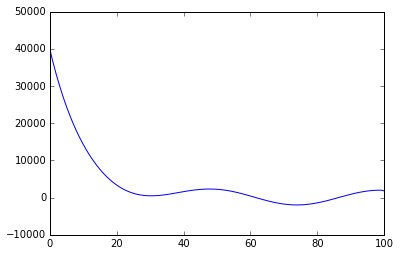

In [283]:
plt.plot(a[niter])

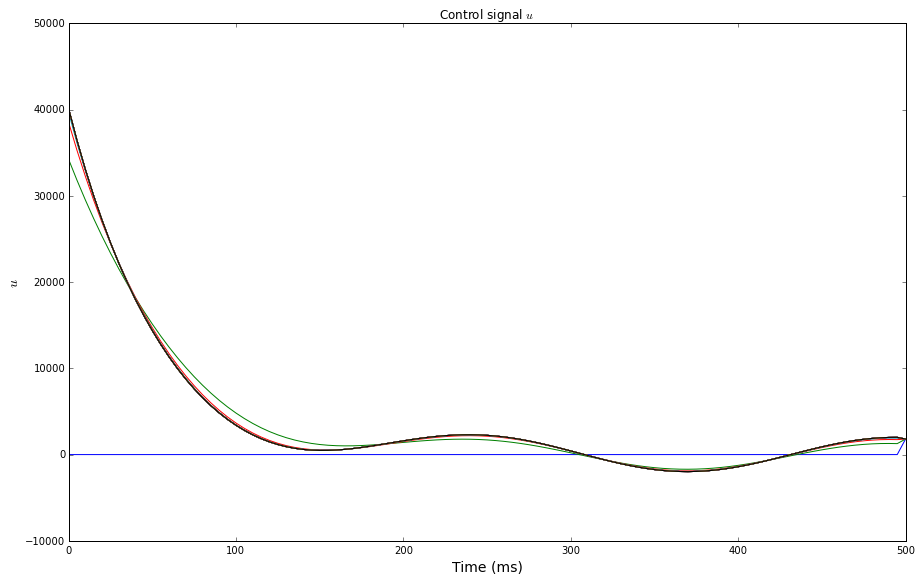

In [284]:
plot_signal(a, 50, 1000, 0., 0.5, 0.005)

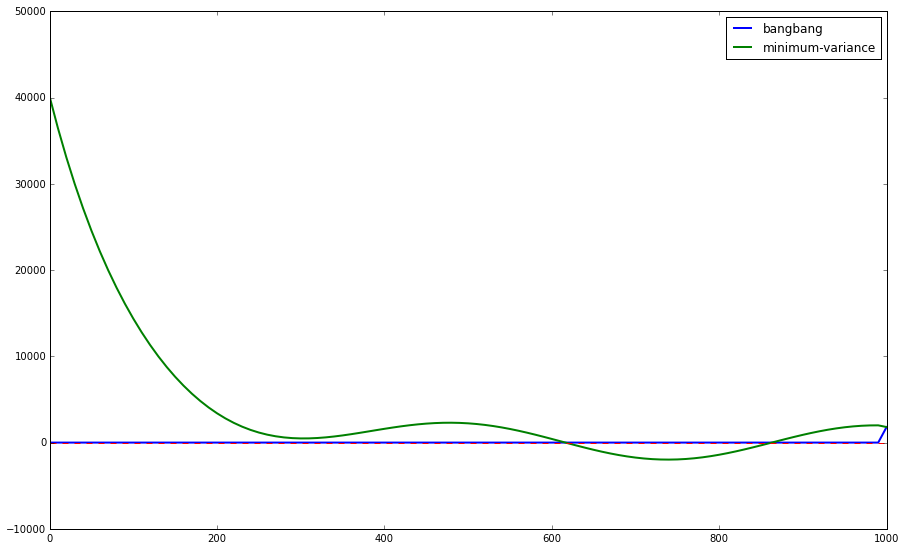

In [285]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, a[0], lw=2, label="bangbang")
ax.plot(time_ms, a[niter], lw=2, label="minimum-variance")
ax.plot([0,(t_T+t_R)*1000],[0,0],'r--')
ax.legend()

In [286]:
position = np.zeros((niter+1,T+R+1))
velocity = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        mean = expectation(a[i,:], j)
        position[i,j] = mean[0]
        velocity[i,j] = mean[1]

In [192]:
position[0] = np.array([  0.        ,   0.32056377,   1.1069942 ,   2.17598703,
         3.41636262,   4.76068711,   6.1680598 ,   7.61367315,
         9.08248064,  10.42273527,  11.        ,  11.1       ,
        11.2       ,  11.3       ,  11.4       ,  11.5       ,
        11.6       ,  11.7       ,  11.8       ,  11.9       ,
        12.        ,  12.1       ,  12.2       ,  12.3       ,
        12.4       ,  12.5       ,  12.6       ,  12.7       ,
        12.8       ,  12.9       ,  13.        ,  13.1       ,
        13.2       ,  13.3       ,  13.4       ,  13.5       ,
        13.6       ,  13.7       ,  13.8       ,  13.9       ,
        14.        ,  14.1       ,  14.2       ,  14.3       ,
        14.4       ,  14.5       ,  14.6       ,  14.7       ,
        14.8       ,  14.9       ,  15.        ])

In [193]:
velocity[0] = np.array([   0.        ,  118.39973321,  190.2128015 ,  233.76962919,
        260.18818062,  276.21184205,  285.93068398,  291.8254596 ,
        295.40082174,  228.182584  ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ,   20.        ,
         20.        ,   20.        ,   20.        ])

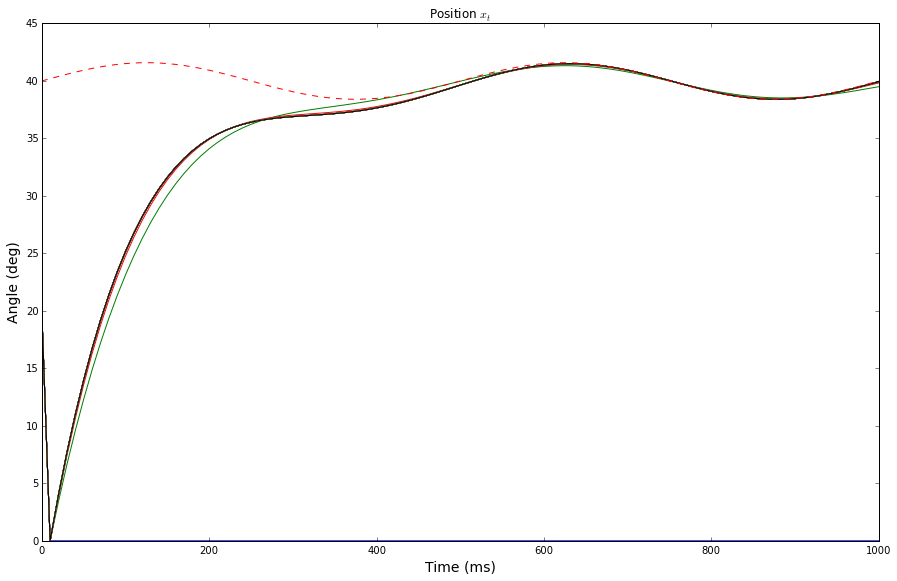

In [292]:
plot_position(position, 50, 1000, 0., 1, 0.01)
plt.plot(np.linspace(0,1000,T+R+1),xx,'r--')


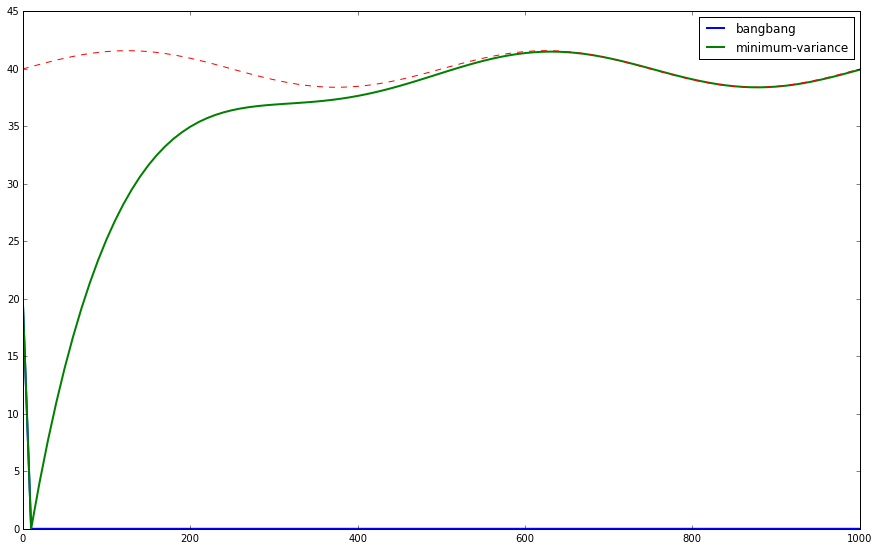

In [288]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, position[0], lw=2, label="bangbang")
ax.plot(time_ms, position[niter], lw=2, label="minimum-variance")
ax.plot(np.linspace(0,(t_T+t_R)*1000,T+R+1),xx,'r--')
ax.legend()


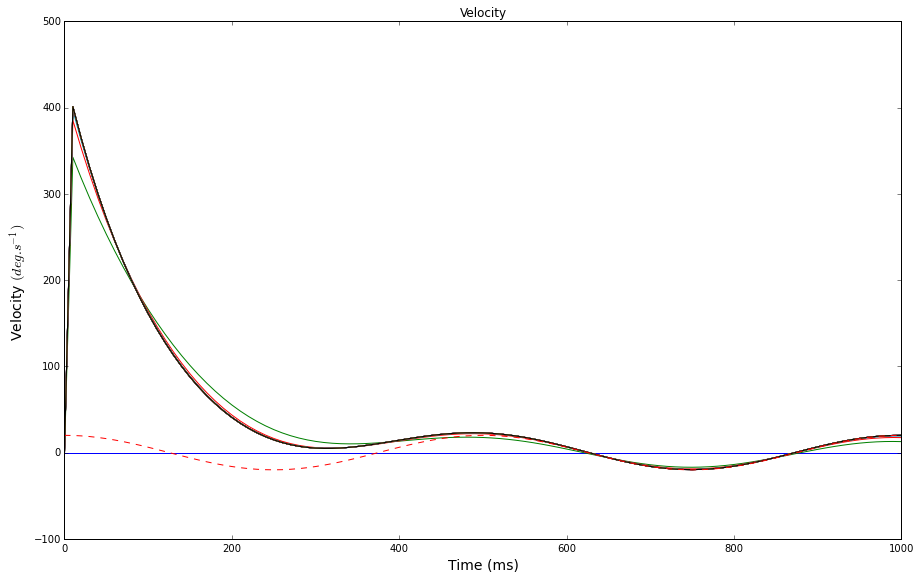

In [290]:
plot_velocity(velocity, 50, 1000, 0., 1, 0.01)
plt.plot(np.linspace(0,(t_T+t_R)*1000,T+R+1),vv,'r--')

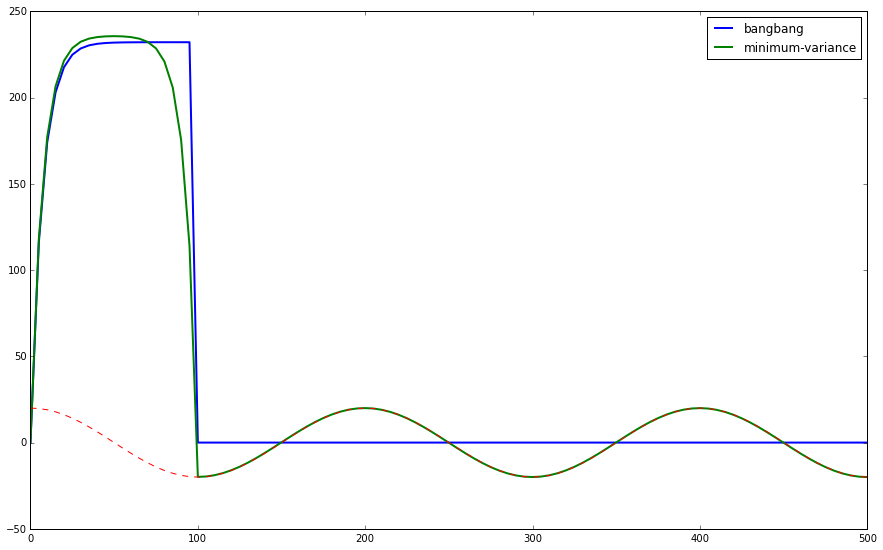

In [129]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, velocity[0], lw=2, label="bangbang")
ax.plot(time_ms, velocity[niter], lw=2, label="minimum-variance")
ax.plot(np.linspace(0,(t_T+t_R)*1000,T+R+1),vv,'r--')
ax.legend()

In [62]:
variancev = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        variancev[i,j] = variance(a[i,:], j)

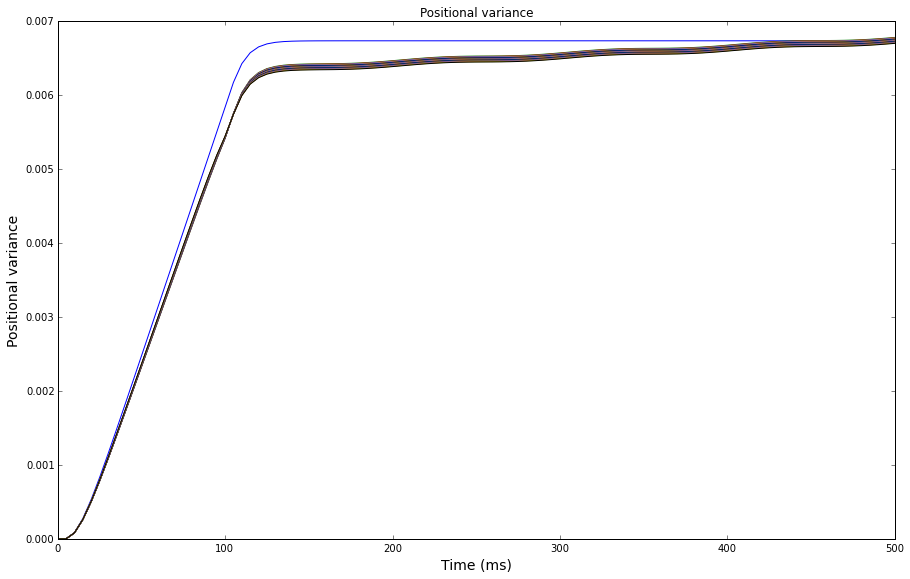

In [63]:
plot_variance(variancev, 250, 5000, 0.1, 0.4, 0.005)

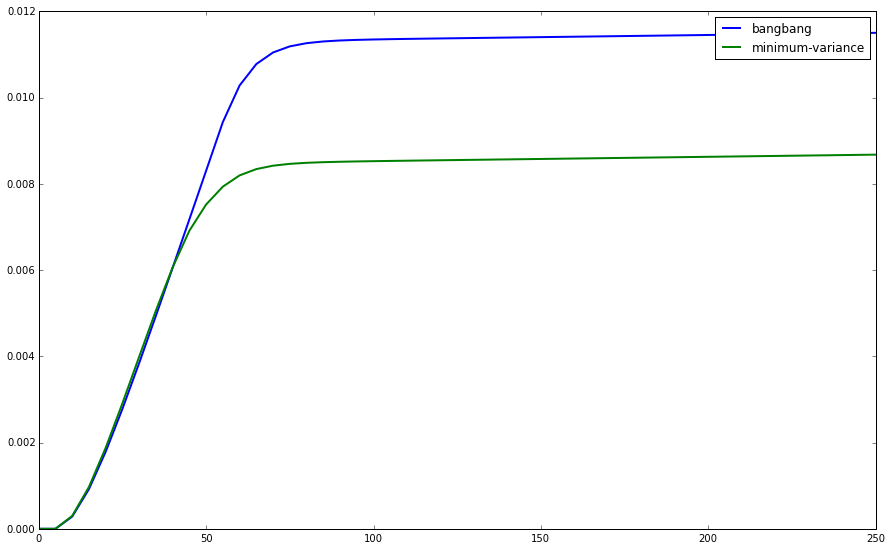

In [32]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, variancev[0], lw=2, label="bangbang")
ax.plot(time_ms, variancev[niter], lw=2, label="minimum-variance")
ax.legend()

In [34]:
cost_p = np.zeros(niter+1)

for i in np.arange(niter+1):
    cost_p[i] = cost(a[i])

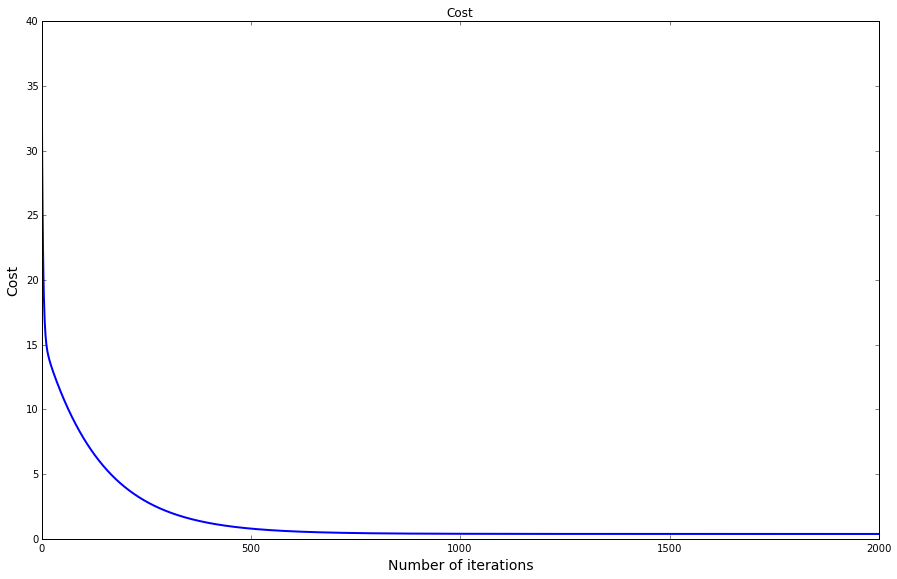

In [40]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(cost_p[0:2000], '-', lw = 2)
ax.set_title('Cost')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)


Finally, we trace the position at time T for each iteration.

In [36]:
positionT = np.zeros(niter+1)

for i in np.arange(niter+1):
    positionT[i] = (expectation(a[i], T))[0]

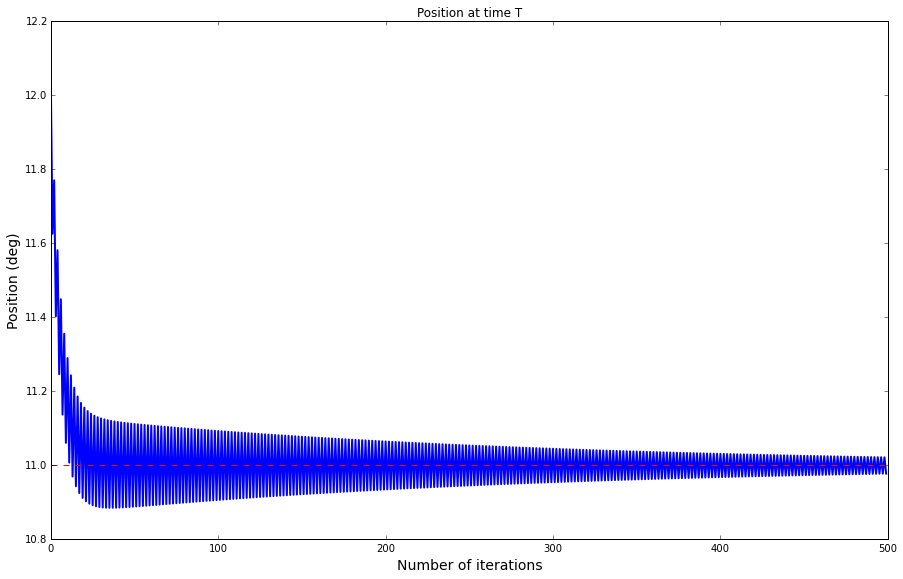

In [65]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(positionT[0:500], '-', lw=2)
ax.set_title('Position at time T')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Position (deg)', fontsize=14)
ax.plot([0,500],[xT[0]+v*t_T ,xT[0]+v*t_T],'r--')


In [33]:
import pickle
import pandas as pd
record = pd.DataFrame()
for i in np.arange(21)*50000:
    record_one = pd.DataFrame([{'signal':a[i],'position':position[i],'velocity':velocity[i],'variance':variancev[i]}],index=[i])
    record = pd.concat([record, record_one])
record.to_pickle('/home/baptiste/Documents/2017_OptimalPrecision/DataRecording/'+'HarrisWolpertPursuit_dt=0.005_beta=100_m=1'+'.pkl')